# AutoMecAD: ML Prototyping and Testing

This notebook is used for the prototyping and evaluation of different ML models to be used for autonomous driving. </br>
</br>
<b> Attention: </b> You will <b> need </b> the Jupyter Notebook installed in order to run this notebook. We also recomend to install the conda enviroment with python 3.8 (Anaconda or miniconda) for an easier dependency management (install AutoMec-AD/requirements.txt)

In [8]:
# Visualization tools
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px

# Data manipulation
from imgaug import augmenters as iaa
import pandas as pd
import numpy as np
import glob
import cv2

# ML Libraries
from tensorflow.keras.layers import Convolution2D, Flatten, Dense, Dropout,  \
TimeDistributed, ConvLSTM2D, Input, BatchNormalization, MaxPooling2D
from tensorflow.python.keras.engine.sequential import relax_input_shape
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

# Other
from PIL import Image
import datetime
import pprint
import random
import shutil 
import yaml
import os

pd.options.plotting.backend = "plotly"

2022-09-05 17:34:06.794679: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/nel/.local/lib/python3.8/site-packages/cv2/../../lib64:/home/nel/catkin_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu
2022-09-05 17:34:06.794703: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Saving the original dataset
If you want to store the augmented images in your disk, or join multiple datasets, you should clone the IMGs and logs to a new dataset and use it.

In [3]:
# path to the folder, or to the new folder to be created 
PATH = "../data/gazebo-10-08-15h02m17s/"

Uncomment if you want to create a new folder for a new dataset

In [4]:
# # directory used to retrive images, steering angles and save new augmented images
# try:
#     shutil.rmtree(PATH)
# except:
#     print("tree not found")
#
# os.mkdir(PATH)

Uncomment the code below if you want to create the new 'driving_log.csv' <br>
Change the variable <code> PATHS </code> to choose the datasets that you want to join

In [5]:
# data = ""

# # CHOOSE YOUR SETS, INSERT THE CORRESPONDED PATHS TO THOSE SETS
# PATHS = ["setX40/", "setX42/"]

# for i, path_log in enumerate(PATHS):
#     file_data = ''
#     with open(os.path.join(path_log, 'driving_log.csv')) as fp:
#         file_data = fp.read()
#     file_data = file_data + '\n' if i < len(path_log)-1 else file_data # the last file read doesnt need the line break
#     data = data + file_data

# with open(PATH + 'driving_log.csv', 'w') as fp:
#     fp.write(data)

Using your file manager to copy all the images and paste in the new dataset is faster. </br>
Use only this piece of code if you don't want to manually paste them.

In [6]:
# DEMORA MUITO TEMPO

# os.mkdir(os.path.join(PATH, 'IMG/'))

# for path_img in PATHS:
#     dir_ = os.listdir(os.path.join(path_img, 'IMG/'))
#     for file in dir_:
#         print(dir_)
#         shutil.copy(os.path.join(path_img + 'IMG/', file), PATH + 'IMG/')

# dir_ = os.listdir(PATH + 'IMG/')
# print(len(dir_))

### Configurations

In [7]:
epochs = 20 
steps_per_epoch = 100 
batch_size_train = 20
training_flag = 1
batch_size_val = 25
validation_flag = 0
validation_steps = 50   

image_width = 320
image_height = 160

### Load data

In [8]:
columns = ['img_name','steering', 'velocity'] 
df = pd.read_csv(os.path.join(PATH, 'driving_log.csv'), names = columns)

del df["velocity"] # not in use, currently

df.head()

,img_name,steering
0,2022_8_10__15_2_19__782837.jpg,0.0
1,2022_8_10__15_2_19__828617.jpg,0.0
2,2022_8_10__15_2_19__860741.jpg,0.0
3,2022_8_10__15_2_19__893845.jpg,0.0
4,2022_8_10__15_2_19__926541.jpg,0.0


# Image Data  Visualization

In case you want to visualize the camera images

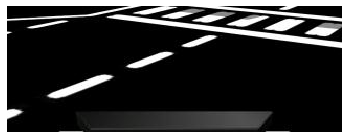

In [9]:
imgv_path = os.path.join(PATH, "IMG/")
imgsv = os.listdir(imgv_path)
rand_integer = random.randint(0, len(imgsv))
imgv = cv2.imread(imgv_path + imgsv[rand_integer], cv2.IMREAD_COLOR)
imgv_cropped = imgv[40:, :]
plt.imshow(imgv_cropped)
plt.axis("off")
plt.show()

## Data Annotation

Annote Images with the Steering values (also known as labeling)

In [10]:
img_names = [os.path.join(PATH, "IMG", df.iloc[i].img_name) for i in range(df.shape[0])]
data  = np.column_stack((img_names, df.steering)) 

img_paths = data[:, 0] 
steerings = data[:, 1].astype(float)

## 3-way Split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(img_paths, steerings, test_size=0.11, random_state=5)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.11, random_state=5)

print('Total Training Images: ', len(x_train))
print('Total Validation Images: ', len(x_val))
print('Total Testing Images: ', len(x_test)) 

Total Training Images:  914
Total Validation Images:  113
Total Testing Images:  128


### Histogram of the test set

In [12]:
nbins_test              = 31 # Has to be an odd number so we have zero at the center
freq_test, bins_test    = np.histogram(y_test, bins=nbins_test)

"""
Centered bins: 
    This creates a Bin with zero value for the center 
    (wich is what we expect from most of the driving input)
"""
cbins_test = (bins_test[:-1] + bins_test[1:])*0.5     

fig = px.bar(x        = cbins_test, 
             y        = freq_test, 
             labels   = {'x' : 'Steering Angle', 'y' : 'Frequency  (Log Scale)'}, 
             title    = "Steering Angle Distribuiton: TEST SET",
             template ="plotly_dark",
             log_y    = False) #True

fig.show()

### Histogram of the Validation Set

In [13]:
nbins_val              = 31        # Has to be an odd number so we have zero at the center
freq_val, bins_val    = np.histogram(y_val, bins=nbins_val)

"""
Centered bins: 
    This creates a Bin with zero value for the center 
    (wich is what we expect from most of the driving input)
"""
cbins_val = (bins_val[:-1] + bins_val[1:])*0.5     

fig = px.bar(x        = cbins_val, 
             y        = freq_val, 
             labels   = {'x' : 'Steering Angle', 'y' : 'Frequency  (Log Scale)'}, 
             title    = "Steering Angle Distribuiton: VALIDATION SET",
             template ="plotly_dark",
             log_y    = False) #True

fig.show()

### Balance Validation Set

In [14]:
keep_nsamples_val = 500

for i in range(nbins_val): 
    
    idx_rm = shuffle([ idx for idx, steering_value in enumerate(y_val)
                               if steering_value >= bins_val[i] and steering_value <= bins_val[i+1] ])
    
    y_val = np.delete(y_val, idx_rm[keep_nsamples_val:]) 
    x_val = np.delete(x_val, idx_rm[keep_nsamples_val:]) 

print('Total val Images: ', len(x_val))

Total val Images:  113


### Balanced Histogram of the Validation Set

In [15]:
freq_val, _ = np.histogram(y_val, nbins_val) # we already have our bins created...  steerings steerings

fig = px.bar(x        = cbins_val, 
             y        = freq_val, 
             labels   = {'x' : 'Steering Angle', 'y' : 'Frequency'}, 
             title    = "Steering Angle Distribuiton: VALIDATION SET (Trimmed)",
             template ="plotly_dark")

fig.show()  

## Balancing the Training Dataset  

###  Histogram

In [16]:
nbins         = 31        # Has to be an odd number so we have zero at the center
freq, bins    = np.histogram(y_train, bins=nbins)

"""
Centered bins: 
    This creates a Bin with zero value for the center 
    (wich is what we expect from most of the driving input)
"""
cbins = (bins[:-1] + bins[1:])*0.5     

fig = px.bar(x        = cbins, 
             y        = freq, 
             labels   = {'x' : 'Steering Angle', 'y' : 'Frequency '}, 
             title    = "Steering Angle Distribuiton (in Log Scale)",
             template ="plotly_dark",
             log_y    = False) #True

fig.show()

### Minority class OverSampling



The objective of this code was to oversampling the minority classes to be in equal frequency as the others... <br> Commented because it didn't gave much gain in performance to the CNN models.

In [17]:
# #Set threshold for the minority class
# threshold_frequency = 100 # look the histogram to seek for the minority classes...

# threshed_bins = np.array([[cb, f] for cb,f in zip(cbins, freq) if f < threshold_frequency])

# mid_idx = int((len(threshed_bins)-1)/2)

# far_pos_bin = threshed_bins[-1][0]
# center_pos_bin = threshed_bins[mid_idx+1][0]
# center_neg_bin = threshed_bins[mid_idx][0]
# far_neg_bin = threshed_bins[0][0]

Augmented Image pipeline for the minority classes

In [18]:
# # AUGMENTED IMAGRE PIPELINE GENERATOR ,,,,
# seq = iaa.Sequential([
#     iaa.Sometimes(0.30, iaa.MotionBlur(k=15, angle=[-60, 60])), 
#     iaa.Sometimes(0.50, iaa.LinearContrast((0.5, 1.9))),
#     iaa.Sometimes(0.20, iaa.Affine(shear=(-8, 8))),
#     iaa.Sometimes(0.10, iaa.SaltAndPepper(0.05))
# ])  

In [19]:
# counter = 0
# for img_path, steer in zip(x_train, y_train): #img_paths steerings
#     # if img is undersampled...
#     if (steer <= center_neg_bin and steer >= far_neg_bin) or (steer >= center_pos_bin and steer <= far_pos_bin): 
        
#         nimg = img_path.split(".")
#         #create 8 augmented images  
#         imgs = np.array( 
#             [ seq(images=[cv2.imread(img_path, cv2.IMREAD_COLOR)])[0] for i in range(3) ]  #530 8
#         )
#         for i,img in enumerate(imgs): 
#             # create a file name...
#             name_file = nimg[0]+"_{}.".format(i)+nimg[1]
#             # save new images... 
#             Image.fromarray(img).save(name_file)
#             #update 
#             #new_row = np.array([name_file, steer])
#             #data = np.vstack((data, new_row.reshape(-1, 2)))
#             #img_paths = data[:, 0]
#             #steerings = data[:, 1].astype(float)
#             x_train = np.append(x_train, name_file)
#             y_train = np.append(y_train, steer)
#             #df.append(pd.DataFrame(new_row.reshape(1,-1), columns=list(df)), ignore_index=True) # dont work...
#             print(counter)
#             counter = counter + 1

###  Undersampling
</br>
<!-- <font size="3"> -->
Iterates trough the bins... </br> </br>
Checks if a given steering angle fits in the bin, which it means that is a part of a bin to crop</br> </br>
Shuffles data fitted into a bin and keep only <code> keep_nsamples </code> 
<!-- </font> -->

In [20]:
keep_nsamples = 1900

for i in range(nbins):   
    
    idx_rm = shuffle([ idx for idx, steering_value in enumerate(y_train)
                               if steering_value >= bins[i] and steering_value <= bins[i+1] ]) # shuffle data
    
    x_train = np.delete(x_train, idx_rm[keep_nsamples:])
    y_train = np.delete(y_train, idx_rm[keep_nsamples:])

### Histogram with data balanced

In [21]:
freq, _ = np.histogram(y_train, nbins) # we already have our bins created...

fig = px.bar(x        = cbins, 
             y        = freq, 
             labels   = {'x' : 'Steering Angle', 'y' : 'Frequency'}, 
             title    = "Steering Angle Distribuiton (Trimmed)",
             template ="plotly_dark",
             log_y    = False)

fig.show()  

print("Total Training Images: ", len(x_train))

Total Training Images:  914


## Data Augmentation

### Image Pre-Processing

In [22]:
def pre_processing(img, img_width=320, img_height=160, normalization="yes"):
    # Cropping Region of intrest, Ajust with Gazebo and use Andre Code in the Future
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV) # For better jornalization 
    
    img = cv2.GaussianBlur(img, (3, 3), 0) 
    
    img = cv2.resize(img, (img_width, img_height))  # NIVIDA uses 200x66

    if normalization == "yes":
        img = img/255

    return img 

In [23]:
def augmentImage(imgPath, steering):
    # Function: Add randomness to the data set by applying random "filters"

    img = mpimg.imread(imgPath)

    # Translation... PAN
    if np.random.rand() < 0.30:
        pan = iaa.Affine(translate_percent = {'x': (-0.1, 0.1) , 'y': (-0.1, 0.1)} )
        img = pan.augment_image(img)  # Add a pan to img 5555 5   

    # Zoom 
    if np.random.rand() < 0.30:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)

    # Brightness
    if np.random.rand() < 0.30:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)
    
    #Motion Blur
    if np.random.rand() < 0.30:
        motion_blur = iaa.MotionBlur(k=15, angle=[-60, 60])
        img = motion_blur.augment_image(img)
        
    #Contrast  
    if np.random.rand() < 0.30:
        lin_contrast = iaa.LinearContrast((0.5, 1.9))
        img = lin_contrast.augment_image(img)
    
    # Shear Operation
    if np.random.rand() < 0.30:
        shear_img = iaa.Affine(shear=(-8, 8))
        img = shear_img.augment_image(img)
    
    # Noise
    if np.random.rand() < 0.30:
        noise = iaa.SaltAndPepper(0.05)
        img = noise.augment_image(img)
    
    # Random Ereasing / Occlusion
    if np.random.rand() < 0.30:
        occlusion = iaa.Cutout(nb_iterations=(1, 5), size=0.2, squared=False)
        img = occlusion.augment_image(img)
        
    # Flip
    if np.random.rand() < 0.30:
        img = cv2.flip(img, 1)  
        steering = - steering

    return img, steering

In [24]:
def batchGen(imagesPath, steeringList, batchSize, trainFlag, imgwidth, imgheight):
    # Creates a batch and applies augmentation
    while True:
        imgBatch = [] 
        steeringBatch = []   

        for i in range(batchSize):
            # Gets a random image and augments it
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
            img = pre_processing(img, imgwidth, imgheight)

            imgBatch.append(img)
            steeringBatch.append(steering)

        yield (np.asarray(imgBatch), np.asarray(steeringBatch)) 

## CNN Models

In [25]:
def cnn_nvidia(imgwidth, imgheight, nchannels): 
    
    model = Sequential()
    model.add(Convolution2D(24, (5, 5), (2, 2), input_shape=(imgheight, imgwidth, nchannels), activation='relu'))
    model.add(Convolution2D(36, (5, 5), (2, 2), activation='relu'))
    model.add(Convolution2D(48, (5, 5), (2, 2), activation='relu'))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(Convolution2D(64, (3, 3), activation='relu'))

    model.add(Flatten())
    
    model.add(Dense(100, activation='relu'))  
    
    model.add(Dense(50, activation='elu'))
    
    model.add(Dense(10, activation='elu'))
   
    model.add(Dense(1)) 

    model.compile(Adam(learning_rate=0.0001), loss='mse')
    
    return model

In [26]:
#steps_per_epoch=32
#epochs=25
def cnn_rota(imgwidth, imgheight):
    
    model = Sequential()
    
    model.add(Convolution2D(8, (5, 5), (2, 2), input_shape=(imgheight, imgwidth, 3), activation='relu'))
    model.add(Convolution2D(16, (5, 5), (2, 2), activation='relu'))
    model.add(Convolution2D(32, (5, 5), (2, 2), activation='relu'))
    model.add(Convolution2D(32, (5, 5), (1, 1), activation='relu'))
    
    model.add(Flatten())
    
    model.add(Dense(375, activation='relu'))
    #model.add(Dropout(rate=0.20)) #probability
    model.add(Dense(125, activation='relu'))
    #model.add(Dropout(rate=0.10)) #probability
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation='tanh'))
    
    model.compile(Adam(learning_rate=0.0001), loss='mse')
    
    return model

## RNN Model

RNN model currently doesn't work, but it is interesting to see in the future

In [27]:
# import toolz
# from toolz.itertoolz import sliding_window

# seq_len = 41

# def create_sequences(size, data):
#     sequence = list(sliding_window(size, data))
#     sequence = np.array(sequence)
#     return sequence

# metax = create_sequences(seq_len, img_paths)
# metay = create_sequences(seq_len, steerings)

# x_train_lstm, x_test_lstm, y_train_lstm, y_test_lstm = train_test_split(metax, metay, test_size=0.10, random_state=5)
# x_train_lstm, x_val_lstm, y_train_lstm, y_val_lstm = train_test_split(x_train_lstm, y_train_lstm, test_size=0.10, random_state=5)


# print(x_train_lstm.shape)

# def batchGen_lstm(imagesPath, steeringList, batchSize, trainFlag, imgwidth, imgheight):
#     # Creates a batch and applies augmentation
#     while True:
#         imgBatch = [] 
#         steeringBatch = []   

#         for i in range(batchSize):
#             img_seqs = []
#             steer_seqs = []
#             for j in range(seq_len):
#                 img = mpimg.imread(imagesPath[i][j])
#                 steering = steeringList[i][j]
#                 img = pre_processing(img, imgwidth, imgheight)
#                 img_seqs.append( img)
#                 steer_seqs.append( steering)
                
#             imgBatch.append(np.array(img_seqs))
#             steeringBatch.append(np.array(steer_seqs))
        
#         imgBatch = shuffle(imgBatch)
#         steeringBatch = shuffle(steeringBatch)
        
#         print(np.array(steeringBatch).shape)
        
#         yield (np.asarray(imgBatch), np.asarray(steeringBatch)) 
        

# def cnn_lstm(imgwidth=320, imgheight=160):     
#     model = Sequential()##########
    
#     model.add(ConvLSTM2D(filters = 24, 
#                          kernel_size = (5, 5), 
#                          strides=(2, 2),
#                          activation = 'tanh',
#                          data_format = "channels_last",
#                          recurrent_dropout=0.2, 
#                          return_sequences=True, 
#                          input_shape = (seq_len, imgwidth, imgheight, 3))) 
#     model.add(TimeDistributed(Dropout(0.2)))
    
#     model.add(ConvLSTM2D(filters = 36, 
#                          kernel_size = (5, 5), 
#                          strides=(2, 2),
#                          activation = 'tanh',
#                          data_format = "channels_last",
#                          recurrent_dropout=0.2, 
#                          return_sequences=True, 
#                          input_shape = (seq_len, imgwidth, imgheight, 3))) 
#     model.add(TimeDistributed(Dropout(0.2)))
    
#     model.add(ConvLSTM2D(filters = 48, 
#                          kernel_size = (5, 5), 
#                          strides=(2, 2),
#                          activation = 'tanh',
#                          data_format = "channels_last",
#                          recurrent_dropout=0.2, 
#                          return_sequences=True, 
#                          input_shape = (seq_len, imgwidth, imgheight, 3))) 
#     model.add(TimeDistributed(Dropout(0.2)))
    
#     model.add(ConvLSTM2D(filters = 64, 
#                          kernel_size = (3, 3),
#                          activation = 'tanh',
#                          data_format = "channels_last",
#                          recurrent_dropout=0.2, 
#                          return_sequences=True, 
#                          input_shape = (seq_len, imgwidth, imgheight, 3))) 
#     model.add(TimeDistributed(Dropout(0.2)))
    
#     model.add(ConvLSTM2D(filters = 64, 
#                          kernel_size = (3, 3),
#                          activation = 'tanh',
#                          data_format = "channels_last",
#                          recurrent_dropout=0.2, 
#                          return_sequences=True, 
#                          input_shape = (seq_len, imgwidth, imgheight, 3))) 
#     model.add(TimeDistributed(Dropout(0.2)))
    
#     model.add(Flatten()) 
    
#     #model.add(Dense(375, activation='relu'))
#     #model.add(Dropout(rate=0.20)) #probability
#     #model.summary()
#     ##model.compile(Adam(learning_rate=np.exp(-5)), loss='mse')
#     model.add(Dense(125, activation='relu'))
#     model.add(Dense(25, activation='relu'))
#     model.add(Dense(1, activation='tanh'))
    
#     model.compile(Adam(learning_rate=0.0001), loss='mse')
    
#     return model

## CNN Training

In [28]:
model = cnn_nvidia(imgwidth=320, imgheight=160, nchannels=3)
#model = load_model('cnn_40_42_1200epochs_0015.h5') # you can also load a pre-trained model...
model.summary()   

2022-08-10 15:03:37.515436: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-10 15:03:37.515464: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (shedinja): /proc/driver/nvidia/version does not exist
2022-08-10 15:03:37.515675: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 158, 24)       1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 77, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 37, 48)        43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 35, 64)        27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 33, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 27456)             0         
                                                                 
 dense (Dense)               (None, 100)               2

In [72]:
cp_callback = ModelCheckpoint(filepath="../../models/callbacks/cp.ckpt", save_weights_only=True, verbose=1)

history = model.fit(
    batchGen(x_train, y_train, batch_size_train, training_flag, image_width, image_height),
    steps_per_epoch  = steps_per_epoch,
    epochs           = epochs,
    validation_data  = batchGen(x_val, y_val, batch_size_val, validation_flag, image_width, image_height),
    validation_steps = validation_steps,
    callbacks        = [cp_callback])

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.0028
Epoch 00001: saving model to ../../models/callbacks/cp.ckpt
100/100 [==============================] - 21s 209ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 2/20
 79/100 [======================>.......] - ETA: 3s - loss: 0.0032

KeyboardInterrupt: 

In [30]:
dataframe = pd.DataFrame(history.history)


fig = px.line(dataframe, 
              title    = 'Learning Curve', 
              labels   = {'x' : 'Epoch', 'y' : 'Loss Value '}, 
              template = "plotly_dark")

fig.show()

## Model Prediction and Evaluation

### Compute Prediction

Convert image paths to pre-processed opencv images

In [31]:
x_test_images = np.asarray(
    [ pre_processing(cv2.imread(img_file), image_width, image_height) for img_file in x_test]
)   

Predict steering based on the test set

In [32]:
steering_predict = model.predict(x_test_images)

### Model Evaluation 

In [33]:
mse = mean_squared_error(y_test, steering_predict)
print("Mean Squared Error: ", mse)
#count_positives = 0

Mean Squared Error:  0.0017240177473671313


### Seeing the results

Uncomment if you want to see images with data augmentation techniques and so on...

In [34]:
# def pre_process(img, img_width=320, img_height=160, normalization="yes"):
    
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # For better jornalization
    

#     ret,img = cv2.threshold(img,190,255,cv2.THRESH_BINARY)
    
#     img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, (10, 10))
    
#     img = cv2.GaussianBlur(img, (3, 3), 0)   
    
#     img = cv2.resize(img, (img_width, img_height))  # NIVIDA uses 200x66
    
#     if normalization == "yes":
#         img = img/255

#     return img 

# def augment_Image(imgPath):
#     # Function: Add randomness to the data set by applying random "filters"
    
#     img = imgPath

#     # Translation... PAN
#     if np.random.rand() < 0.30:
#         pan = iaa.Affine(translate_percent = {'x': (-0.1, 0.1) , 'y': (-0.1, 0.1)} )
#         img = pan.augment_image(img)  # Add a pan to img 5555 5   

#     # Zoom 
#     if np.random.rand() < 0.30:
#         zoom = iaa.Affine(scale=(1, 1.2))
#         img = zoom.augment_image(img)

#     # Brightness
#     if np.random.rand() < 0.30:
#         brightness = iaa.Multiply((0.2, 1.2))
#         img = brightness.augment_image(img)
    
#     #Motion Blur
#     if np.random.rand() < 0.30:
#         motion_blur = iaa.MotionBlur(k=15, angle=[-60, 60])
#         img = motion_blur.augment_image(img)
        
#     #Contrast  
#     if np.random.rand() < 0.30:
#         lin_contrast = iaa.LinearContrast((0.5, 1.9))
#         img = lin_contrast.augment_image(img)
    
#     # Shear Operation
#     if np.random.rand() < 0.30:
#         shear_img = iaa.Affine(shear=(-8, 8))
#         img = shear_img.augment_image(img)
    
#     # Noise
#     if np.random.rand() < 0.30:
#         noise = iaa.SaltAndPepper(0.05)
#         img = noise.augment_image(img)
    
#     # Random Ereasing / Occlusion
#     if np.random.rand() < 0.30:
#         occlusion = iaa.Cutout(nb_iterations=(1, 5), size=0.2, squared=False)
#         img = occlusion.augment_image(img)
        
#     # Flip
#     if np.random.rand() < 0.30:
#         img = cv2.flip(img, 1)

#     return img #, steering

In [35]:
def display_image():
    
    rand_integer = random.randint(0, len(x_val))
    
    selectx = x_val[rand_integer]
    #img = augment_Image(pre_process(mpimg.imread(selectx), img_width=320, img_height=160, normalization="no"))
    img = mpimg.imread(selectx)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()
    
    y_test_aux = y_val[rand_integer]
    y_pred = steering_predict[rand_integer]
    print("Predicted angle: ", round(y_pred[0], 5))
    print("Real angle:      ", round(y_test_aux, 5))

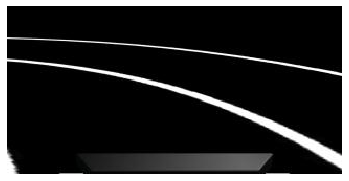

Predicted angle:  -0.10557
Real angle:       0.176


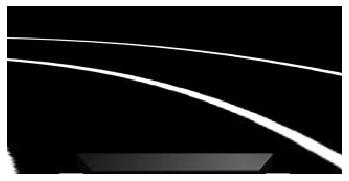

Predicted angle:  0.07873
Real angle:       0.176


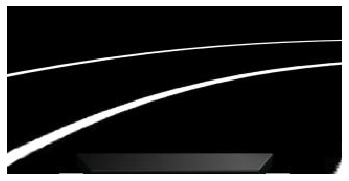

Predicted angle:  0.02536
Real angle:       -0.206


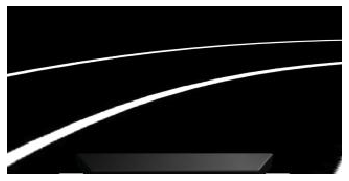

Predicted angle:  -0.02542
Real angle:       -0.265


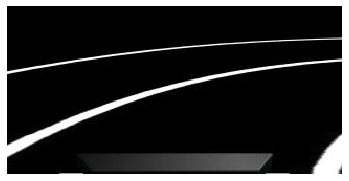

Predicted angle:  -0.20981
Real angle:       -0.147


In [36]:
display_image()
display_image()
display_image()
display_image()
display_image()

## Save the model

### Defining variables

In [10]:
# Read YAML file
with open(PATH + "info.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)
data_loaded['dataset']['name'] = PATH.split('/')[3]

['..', 'data', 'gazebo-10-08-15h02m17s', '']


In [67]:
cnn_model_name = 'rota'
val_loss = '0.01'
test_loss = '0.02'
model_evaluation = '5/10'
ml_comments = 'correu mt bem... nao gostei'
current_date = datetime.datetime.now().strftime("%d-%m-%Y-%H:%M:%S")

### Model

In [68]:
modelname = cnn_model_name + '-' + current_date + '-' + val_loss
model.save('../models/' + modelname + '.h5')

### YAML

In [69]:
info_data = dict(
    model = dict(
        name = modelname,
        developer = os.getenv('automec_developer'),
        date = current_date,
        ml_arch = {"name":cnn_model_name, "epochs":epochs, 
                   "batch_size_train":batch_size_train, 
                   "batch_size_val":batch_size_val, "training_flag":training_flag,
                   "validation_flag":validation_flag, "validation_steps":validation_steps,
                   "val_loss":val_loss, "tes_loss":test_loss},
        model_eval = model_evaluation,
        comments = ml_comments
    ),
    dataset = data_loaded['dataset']
)

In [70]:
with open('../models'+'/' + modelname + '.yaml', 'w') as outfile: #info
    yaml.dump(info_data, outfile, default_flow_style=False, sort_keys=False)